# 1. Adding Gaussian Noise

## 1.1 Import Libraries

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv

## 1.2 Read Image and Add Noise

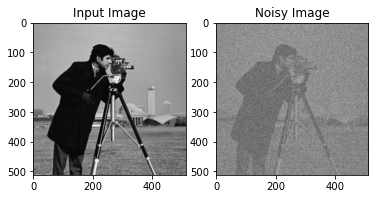

In [3]:
def add_gaussian_noise(img_gray, sigma):
    '''Return image with added gaussian noise'''
    row,col= img_gray.shape
    mean = 0
    gaussian = np.random.normal(mean, sigma, (row, col)) 
    noisy_img = img_gray + gaussian
    return noisy_img

# read in image
img = cv2.imread('data/cameraman.png')
img_gray = rgb2gray(img)
# add gaussian noise
img_gray_noise = add_gaussian_noise(img_gray, 0.5)

# plot results
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.title.set_text('Input Image')
ax2.title.set_text('Noisy Image')
ax1.imshow(img, cmap='gray')
ax2.imshow(img_gray_noise, cmap='gray')

# 2. Denoise with Fast Fourier Transform

## 2.1 Create Masks for Frequencies

In [4]:
def createMask(width, height, size):
    '''Return width by height array of 0s with square with side length size/2 of 1s in the middle'''
    # create array of 0s
    mask = np.zeros((width, height))
    # calculate center
    middle = width//2
    half = size//2
    # from the center replace 0 with 1
    for x in range(middle - half, middle + half):
        for y in range(middle - half, middle + half):
            mask[x][y] = 1
    return mask

## 2.2 Denoise Image Using Fast Fourier Transform

In [5]:
def denoise(img_noise, frequencies):
    '''Take in gray image and denoise by keeping frequencies in FFT'''
    # apply fft
    transformedImage = np.fft.fft2(img_noise)
    # shift zero-frequency components to center
    shiftedImage = np.fft.fftshift(transformedImage)
    # mask frequencies based on desired freqencies to be kept
    maskedImage = np.multiply(shiftedImage, createMask(512, 512, frequencies))
    maskedImage[maskedImage == 0] = 1
    # unshift the frequencies
    unshiftedMaskedImage = np.fft.ifftshift(maskedImage)
    # invert the fourier transform
    inverseTransform = np.fft.ifft2(unshiftedMaskedImage)

    fig,(ax1,ax2) = plt.subplots(1,2)
    ax1.title.set_text('FFT Frequencies')
    ax2.title.set_text('Denoised Image')
    ax1.imshow(np.log(abs(maskedImage)), cmap='gray')
    ax2.imshow(abs(inverseTransform), cmap='gray')

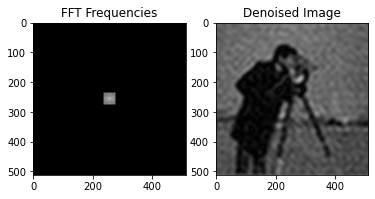

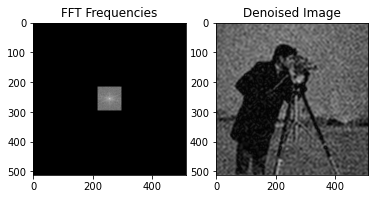

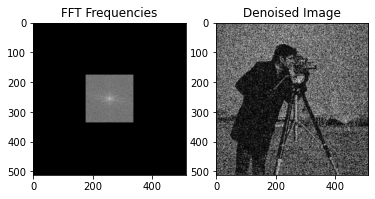

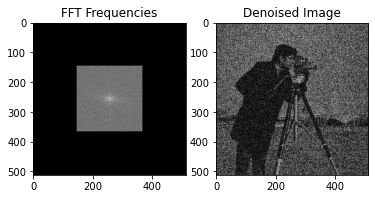

In [6]:
denoise(img_gray_noise, 40)
denoise(img_gray_noise, 80)
denoise(img_gray_noise, 160)
denoise(img_gray_noise, 220)

# 3. Denoise Using Gradient Descent for ROF model with Total Variation Minimization.

## 3.1 X and Y Gradient

Used to find the 'gradient' of the image

In [11]:
def dif_x(image):
    '''Return array of differences between pixels in the x direction'''
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[:,1:cols-1] = image[:,1:cols-1] - image[:,0:cols-2];
    d[:,0] = image[:,0] - image[:,cols-1];
    return d

def dif_y(image):
    '''Return array of differences between pixels in the y dirrection'''
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[1:rows-1, :] = image[1:rows-1, :] - image[0:rows-2, :];
    d[0,:] = image[0,:] - image[rows-1,:];
    return d

## 3.2 Denoise Image Using Gradient Descent for ROF with Total Variation Minimization

In [42]:
img = cv2.imread('data/cameraman.png')
img_gray = rgb2gray(img)
f = u = add_gaussian_noise(img_gray, 0.1)

def getGradient(u):
    '''Return sum of dif_x and dif_y'''
    return dif_x(u) + dif_y(u)

def getEnergy(f, u, l):
    '''Calculate total energy of denoised image'''
    return l*np.sum((np.square(f - u))) + np.sum(np.linalg.norm(getGradient(u)))

def getGrad(f, u, l):
    '''Get gradient of minE'''
    numerator = getGradient(u)
    denominator = np.linalg.norm(dif_x(u)) + np.linalg.norm(dif_y(u)) + 0.000000001
    divergence = getGradient(numerator/denominator)
    return -2*l*(f - u) - divergence
    
iters = []
energy = []
l = 0.01
i = 0
e = 1

# repeat until energy is below 0.5
while e > 0.5:
    grad = getGrad(f, u , l)
    u = u - 0.5 * grad
    iters.append(i)
    i += 1
    e = np.linalg.norm(getGrad(f, u , l))
    energy.append(e)

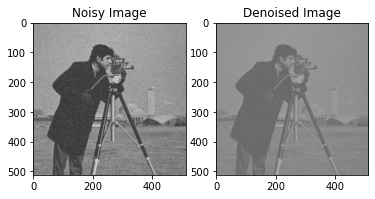

In [43]:
# plot results
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.title.set_text('Noisy Image')
ax2.title.set_text('Denoised Image')
ax1.imshow(f, cmap='gray')
ax2.imshow(u, cmap='gray')


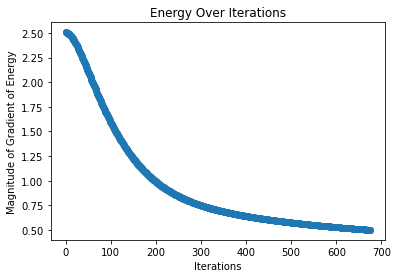

In [44]:
plt.scatter(iters, energy)
plt.xlabel('Iterations')
plt.ylabel('Magnitude of Gradient of Energy')
plt.title('Energy Over Iterations')
plt.show()